# 특정 대학의 검색 빈도 수 시각화

In [88]:
import pandas as pd
from scipy.stats import zscore
import requests, json, urllib.request
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.cm as cm
import folium
import numpy as np
from pyproj import Proj, transform
from pyproj import Transformer
import seaborn as sns
import time

## 네이버 통합 검색어 트랜드 API 요청 함수
네이버 통합 검색어 트랜드 API를 사용하여 검색 빈도 수를 측정하였다.   
해당 API는 최대 5개의 키워드에 대해 빈도 수 값을 상대값으로 제공한다.

In [71]:
client_id="Moj0HWTReuthN1uVNMY0"
client_secret="cTDYs5cjHZ"


# 네이버 통합 검색어 트랜드 API 요청
def trend_api(keyword_list, startDate, endDate, timeUnit):
    url = "https://openapi.naver.com/v1/datalab/search"

    keywordGroups = []
    for keyword in keyword_list:
        group = {"groupName": keyword, "keywords": [keyword]}
        keywordGroups.append(group)

    body = {
        "startDate": startDate,
        "endDate": endDate,
        "timeUnit": timeUnit,
        "keywordGroups": keywordGroups
    }
    body = json.dumps(body)

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type", "application/json")

    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    rescode = response.getcode()

    if rescode == 200:
        response_body = response.read()
        return json.loads(response_body)
    else:
        print(f"HTTP 요청 실패 : {rescode}")
        return None

## 네이버 통합 검색어 트랜드 전처리 함수
하지만 5개 이상의 키워드를 입력하여 데이터를 분석하여야 했기에 다음 과정을 진행하였다.   
1. 입력 데이터를 4개씩 나누어 리스트화 한다.
2. 각 리스트에 임의로 지정한 키워드 "compare"를 넣어 여러번 API를 요청한다.
3. 결과값 데이터는 0~100 사이의 정규화가 끝난 상대적인 데이터의 묶음으로 나온다.
4. 이때, 임의로 "compare"의 절댓값을 100으로 지정하게 된다면 그에 맞는 나머지 데이터들도 임의의 절댓값이 구해진다.
5. 이렇게 구해진 point_ratio 값을 다시 한번 0~100 사이로 정규화 한다.
6. 완성된 DataFrame은 "compare"의 100 값으로, 서로간의 관계 의존성이 추가된채로 비교가 가능한 상태가 된다.

In [68]:
# 입력받은 키워드 리스트를, 'compare'가 포함된 5개 이하의 2차원 배열로 변환
def keyword_split(keyword_list):
    result = []

    for i in range(0, len(keyword_list), 4):
        group = ['compare'] + keyword_list[i:i + 4]
        result.append(group)

    return result


# API 결과 json 을 dataframe으로 생성
def create_df(data):
    rows = []
    for item in data['results']:
        title = item['title']
        for entry in item['data']:
            rows.append({'title': title, 'period': entry['period'], 'ratio': entry['ratio']})

    df = pd.DataFrame(rows)
    df = df.sort_values('period')

    return df


# 데이터 입력받은 뒤, naver_api를 사용하여 요청
def get_trend_info(keyword_list, startDate, endDate, timeUnit):
    each_keyword_list = keyword_split(keyword_list)

    try:
        df_list = []
        for kl in each_keyword_list:
            result = trend_api(kl, startDate, endDate, timeUnit)
            result_df = create_df(result)

            # 첫번째 compare의 ratio값을 가져온뒤 임의값 100으로 비율 게산
            first_compare_ratio = result_df[result_df['title'] == 'compare'].iloc[0]['ratio']
            point_per_ratio = 100 / first_compare_ratio

            # 새로 계산한 ratio 값 추가 후, compare은 삭제
            result_df['point_ratio'] = result_df['ratio'] * point_per_ratio
            result_df = result_df[result_df['title'] != 'compare']
            df_list.append(result_df)
            time.sleep(0.5)
    except Exception as e:
        print(e)
        return "Request ERROR"


    # 가져와졌는지 확인
    print(f"dfList Size : {len(df_list)}")
    if len(df_list) == 0:
        return "No LIST"

    # 가져온 리스트 전부 합치기
    merge_df = pd.concat(df_list, ignore_index=True)

    # 병합한 df들의 point_ratio 값을 Min-Max 정규화로 0~100 설정
    min_point = merge_df['point_ratio'].min()
    max_point = merge_df['point_ratio'].max()
    merge_df['normalize_ratio'] = (merge_df['point_ratio'] - min_point) / (max_point - min_point) * 100
    #print(merge_df)

    return merge_df

## 데이터 요청 및 시각화 처리
아래와 같이 키워드가 6개이기에 2개의 DataFrame을 받았지만, 전처리 함수 과정으로 인해 두 DataFame의 관계가 생성되고,   
 서로 분석 가능한 상태가 되었습니다.

In [82]:
test_keyword = ["인하공전", "유한대", "부천대", "재능대", "경인여대", "김포대"]
df = get_trend_info(test_keyword, "2023-11-30", "2024-11-30", "month")
df

dfList Size : 2


,title,period,ratio,point_ratio,normalize_ratio
0,유한대,2023-11-01,22.57931,156.768757,20.096407
1,부천대,2023-11-01,77.66426,539.225047,76.947947
2,인하공전,2023-11-01,68.45447,475.281227,67.442796
3,재능대,2023-11-01,7.13584,49.544329,4.157661
4,유한대,2023-12-01,29.98001,208.152016,27.734450
...,...,...,...,...,...
73,김포대,2024-09-01,11.57356,44.766433,3.447434
74,김포대,2024-10-01,9.90109,38.297333,2.485812
75,경인여대,2024-10-01,67.42083,260.783206,35.557995
76,경인여대,2024-11-01,100.00000,386.799163,54.290074


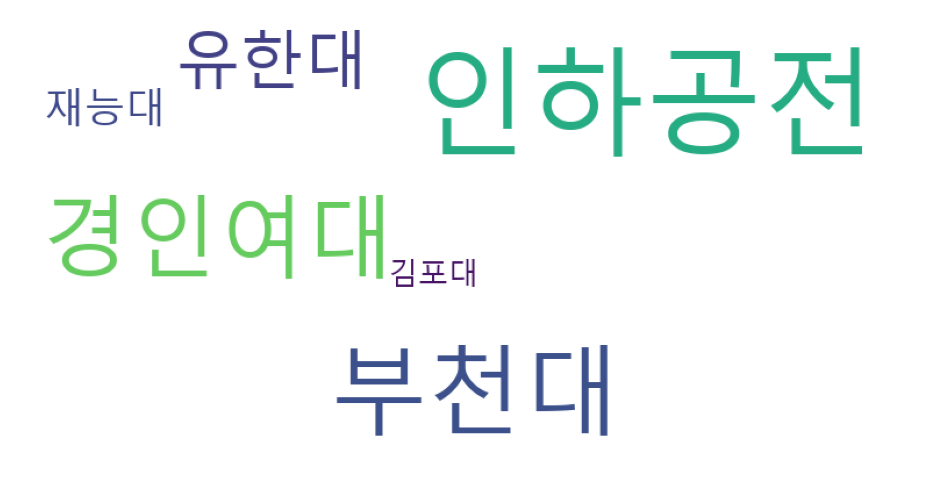

In [91]:
# Ratio 값을 딕셔너리로 변환 하여 WordCloud 생성
#%matplotlib inline
wc_dict = df.groupby('title')['normalize_ratio'].sum().to_dict()

wordcloud = WordCloud(
        font_path="/content/malgun.ttf",
        width=800,
        height=400,
        max_font_size=100,
        background_color="white",
).generate_from_frequencies(wc_dict)

fig = plt.figure(figsize=(12, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

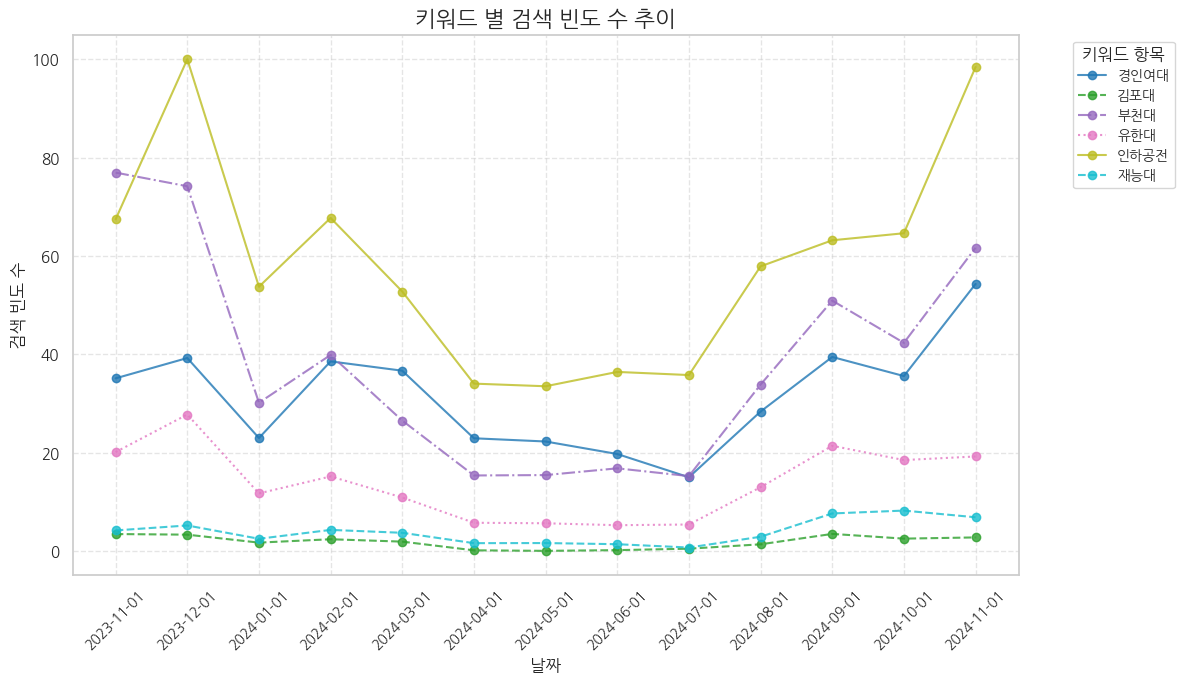

In [94]:
# 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 고유한 title에 따라 색상 및 스타일 설정
unique_titles = df['title'].unique()
colors = cm.tab10(np.linspace(0, 1, len(unique_titles)))
line_styles = ['-', '--', '-.', ':']

# 차트 생성
plt.figure(figsize=(12, 7))
for idx, (title, group) in enumerate(df.groupby('title')):
    color = colors[idx % len(colors)]
    linestyle = line_styles[idx % len(line_styles)]
    plt.plot(
        group['period'],
        group['normalize_ratio'],
        marker='o',
        label=title,
        color=color,
        linestyle=linestyle,
        alpha=0.8
    )

plt.title("키워드 별 검색 빈도 수 추이", fontsize=16)
plt.xlabel("날짜", fontsize=12)
plt.ylabel("검색 빈도 수", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="키워드 항목", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 결론
---
위 그래프를 보면 알 수 있듯이 전체적으로 "인하공전" 이라는 키워드가 검색이 다른 키워드에 비해 비교적 많이 검색이 된다는 것을 알 수 있었다.   
<br>
또한 대학교의 특성상 10,11,12월에 전체적으로 검색량이 증가하는것을 확인할 수 있다.

<br><br><br><br><br><br><br><br>

# ~~추가 프로젝트 내용~~
---
API 요청의 횟수 제한으로 마저 완성하지는 못했습니다.   
요청분산과, 병렬화 등을 사용하여 데이터 재수집 후 다시 업데이트 하겠습니다.   
<br>
1. 공공데이터 포탈의 전국 음식점 데이터셋을 가져와 폐업 시기와 업종 분석
2. 특정 지역의 음식점 리스트를 가져와, 검색 빈도수와 네이버 플레이스의 평점 비교 분석

In [6]:
# 원본 데이터셋 가져오기
txt_df = pd.read_table("/content/drive/MyDrive/fulldata_07_24_04_P_일반음식점.txt", sep=",", on_bad_lines="skip", encoding="cp949")
txt_df.head()

<ipython-input-6-119409e25de5>:1: DtypeWarning: Columns (11,39,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  txt_df = pd.read_table("/content/drive/MyDrive/fulldata_07_24_04_P_일반음식점.txt", sep=",", on_bad_lines="skip", encoding="cp949")


,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,공장판매직직원수,공장생산직직원수,건물소유구분명,보증액,월세액,다중이용업소여부,시설총규모,전통업소지정번호,전통업소주된음식,홈페이지
1,일반음식점,07_24_04_P,3660000,3660000-101-2023-00652,2023-11-20,NaN,3,폐업,2,폐업,...,0.0,NaN,0.0,0.0,N,32.00,NaN,NaN,NaN,NaN
2,일반음식점,07_24_04_P,3550000,3550000-101-2023-00169,2023-11-20,NaN,3,폐업,2,폐업,...,0.0,NaN,0.0,0.0,N,36.10,NaN,NaN,NaN,NaN
3,일반음식점,07_24_04_P,5710000,5730000-101-2023-00460,2023-11-20,NaN,3,폐업,2,폐업,...,0.0,NaN,0.0,0.0,N,42.31,NaN,NaN,NaN,NaN
4,일반음식점,07_24_04_P,3780000,3790000-101-2023-00250,2023-11-15,NaN,3,폐업,2,폐업,...,0.0,NaN,0.0,0.0,N,44.01,NaN,NaN,NaN,NaN
5,일반음식점,07_24_04_P,4060000,4060000-101-2023-00770,2023-11-15,NaN,3,폐업,2,폐업,...,0.0,NaN,0.0,0.0,N,0.00,NaN,NaN,NaN,NaN


## 필요 데이터만 뽑기

In [97]:
pick_df = txt_df.iloc[:, [20, 24, 18, 25, 26, 8, 21]]
pick_df.columns = ["사업장명", "업태구분명", "도로명전체주소", "좌표정보(x)", "좌표정보(y)", "영업상태", "최종수정시점"]
pick_df

,사업장명,업태구분명,도로명전체주소,좌표정보(x),좌표정보(y),영업상태,최종수정시점
1,본전집,기타,"대전광역시 서구 관저중로 86-1, 1층 일부호 (관저동)",230036.040106,311064.997435,2,2024-10-15 10:59:28
2,도깨비,한식,"인천광역시 계양구 안남로573번길 25, 1층 일부호 (효성동)",174214.762779,448093.019037,2,2024-07-23 15:29:44
3,상구맥주,정종/대포집/소주방,"충청북도 청주시 흥덕구 짐대로72번길 41, 1층 111호 (복대동)",238172.135391,347836.102621,2,2023-12-19 14:33:37
4,다 아는 맛,한식,"경기도 성남시 수정구 위례서일로 12, 우남 이타워 프라자 1층 109호 (창곡동)",212084.510780,440356.597367,2,2024-03-29 11:56:19
5,북파주어촌계 장석우,한식,"경기도 파주시 문산읍 임진각로 177, 파주임진각광장",177067.332278,487447.428471,2,2023-11-27 04:15:09
...,...,...,...,...,...,...,...
2176927,원아가든,한식,"광주광역시 서구 용두난산길 46, 1층 (용두동)",183338.073439,178369.322568,1,2017-01-31 13:15:59
2176928,뚱스넥,한식,"광주광역시 남구 제중로 39, 2층 (양림동)",192085.702260,182111.703093,1,2022-08-02 16:18:12
2176929,갈비명가아라네,한식,"광주광역시 남구 군분로 26-1, 1층 (월산동)",190363.418899,181905.028328,1,2020-02-25 09:35:39
2176930,승진이네,한식,"광주광역시 서구 월드컵4강로116번길 5, 1층 (화정동)",188322.201767,183130.570776,1,2019-12-30 10:14:42



## 폐업 시기 분석
폐업 비율이 코로나 시점이나 이후로 오를것으로 예상하였으나, 일반 직장인에서 자영업자로의 전환이 많아져서인지    
2017년도부터 폐업 비율이 매우 높아진다.

<ipython-input-108-63728936c582>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=close_df, x='업데이트일시', palette='viridis', order=range(1999, 2024))


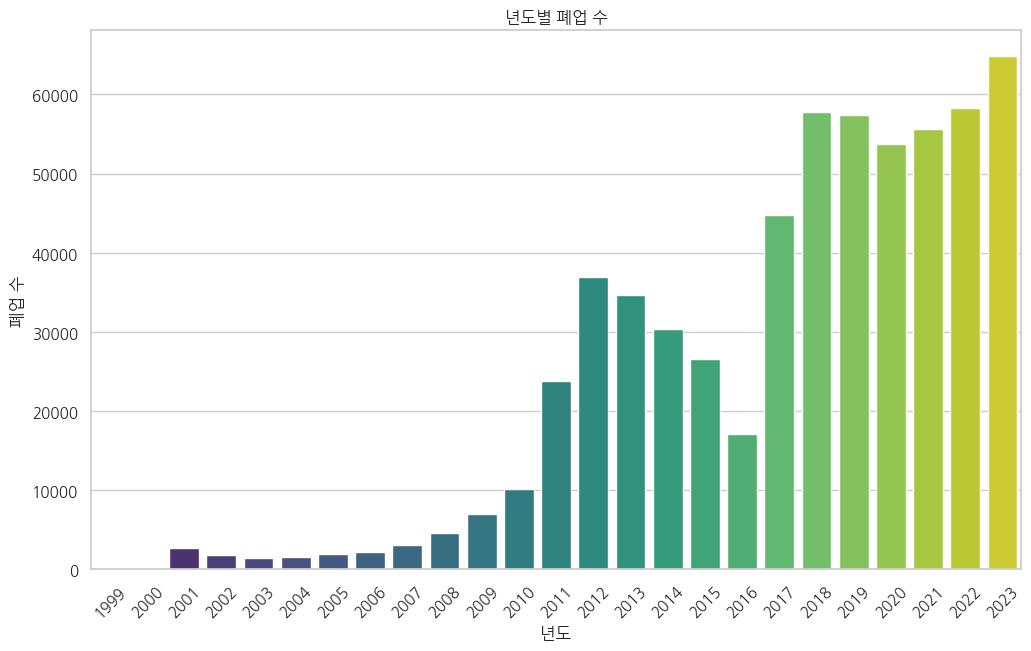

In [108]:
# 시도 추가, 폐업 가게 목록
close_df = pick_df.copy()
close_df['시도'] = close_df['도로명전체주소'].str.split(' ').str[0]
close_df['업데이트일시'] = close_df['최종수정시점'].str[:4]
close_df = close_df.drop(columns="최종수정시점")
close_df = close_df[close_df['영업상태'] == 2]
close_df = close_df.dropna(subset=["시도"])
close_df

plt.figure(figsize=(12, 7))
sns.countplot(data=close_df, x='업데이트일시', palette='viridis', order=range(1999, 2024))
plt.title('년도별 폐업 수')
plt.xlabel('년도')
plt.ylabel('폐업 수')
plt.xticks(rotation=45)
plt.show()

## 데이터 전처리
1. 도로명 주소에서 시도, 시구를 나누어 저장
2. 영업상태 정상만 필터링

In [27]:
new_df = pick_df.copy()

# '도로명전체주소'에서 시도 추출 (공백을 기준으로 첫 번째 항목)
new_df['시도'] = new_df['도로명전체주소'].str.split(' ').str[0]
new_df['시구'] = new_df['도로명전체주소'].str.split(' ').str[1]

# 영업상태 정상만 필터링
new_df = new_df[new_df['영업상태'] == 1]

# TM128(한국 좌표계) -> WGS84(경도, 위도) 변환기 설정
#transformer = Transformer.from_crs("EPSG:5179", "EPSG:4326", always_xy=True)

# 좌표 변환
#new_df[['경도', '위도']] = new_df.apply(
#    lambda row: pd.Series(transformer.transform(row['좌표정보(x)'], row['좌표정보(y)'])),
#    axis=1
#)

new_df

,사업장명,업태구분명,도로명전체주소,좌표정보(x),좌표정보(y),영업상태,시도,시구
1478710,33떡볶이&꼬마김밥 미사리버포레점,분식,"경기도 하남시 미사강변북로 65-1, 미사강변 더샵 리버포레 1층 101호 (선동)",216355.623702,452406.828698,1,경기도,하남시
1478711,중화요리 미식재,중국식,"인천광역시 중구 흰바위로 113, 더 예스 포레스트 2층 205,206호 (운서동)",155439.523172,443179.669702,1,인천광역시,중구
1478712,웨이브라운지 바(Bar),호프/통닭,"부산광역시 동래구 금강공원로26번길 29, 2층 일부호 (온천동)",389423.885905,193211.891622,1,부산광역시,동래구
1478713,4242샌드위치 동래점,경양식,"부산광역시 동래구 온천천로339번길 51, 201동 1층 7호 (낙민동, 포레나 동래)",390304.544719,190552.782902,1,부산광역시,동래구
1478714,백세장수촌 증평점,한식,충청북도 증평군 증평읍 송산로5길 37,252106.125904,366017.067263,1,충청북도,증평군
...,...,...,...,...,...,...,...,...
2176927,원아가든,한식,"광주광역시 서구 용두난산길 46, 1층 (용두동)",183338.073439,178369.322568,1,광주광역시,서구
2176928,뚱스넥,한식,"광주광역시 남구 제중로 39, 2층 (양림동)",192085.702260,182111.703093,1,광주광역시,남구
2176929,갈비명가아라네,한식,"광주광역시 남구 군분로 26-1, 1층 (월산동)",190363.418899,181905.028328,1,광주광역시,남구
2176930,승진이네,한식,"광주광역시 서구 월드컵4강로116번길 5, 1층 (화정동)",188322.201767,183130.570776,1,광주광역시,서구


## 인천광역시 미추홀구에 현재 영업하는 음식점 가져오기

In [36]:
def get_restaurants_by_location(df, sido, sigu):
    filtered_df = df[(df['시도'] == sido) & (df['시구'] == sigu)]
    return filtered_df


sido_name = "인천광역시"        # 원하는 시도
sigu_name = "미추홀구"          # 원하는 시구

restaurants_df = get_restaurants_by_location(new_df, sido_name, sigu_name)
restaurants_names = restaurants_df['사업장명'].tolist()
print(restaurants_names)
print(f"Count : {len(restaurants_names)}")

['원조감자탕 일미집 주안점', 'BBQ인천학익점', '일월오악 롯데인천터미널점', '해늘찹쌀순대국밥 주안점', '뵈르뵈르 인천롯데점', '체다페퍼(도화점)', '술수다', '백남옥손만두 인하대역점', '장원칼국수', '오스틴 타코 롯데백화점 인천점', '피렌체', '용현순대', '숲속의 밤(A FOREST NIGHT)', '백돈 인천주안점', '달떡볶이 주안점', '옆집누나', '치킨매니아 주안점', '목우촌치킨 또래오래 주안점', '토나리 우동 롯데백화점 인천점', '이석덕 생면파스타', '힐링카페', '에스에스오지(ssog) 주안점', '우육미엔 롯데인천점', '(주)한일관', '올드페리도넛 인천아인병원점 1호', '샬롬삼계탕', '더즌매터 인천롯데점', '토담골', '한스델리 주안신기점', '정 냉삼집', '에바돈가츠 인천주안', '달래해장', '한술두술', '정씨고찌', '채채푸드', '덕금도원 인천본점', '자가제빵선명희피자 주안점', '뚝닭', '나우영(NOW YOUNG)', '금강산 식당', '모두애김밥', '장터등갈비&종로닭발', '한식에 진심', '옛날추어탕', '한끼분식', '만나오리', '케이에이(KA)푸드', '광화문참치', '비원', '돼꺽정 주안본점', '무지개맥주 시민공원역점', '동민서푸드', '누리네', '형제닭꼬치', '포코프레', '더블다운버거 주안시민공원역점', '천하육미', '용용불닭발', '포대포', '장터삼겹살', '국밥 참 맛있는 집 인천인하대역점', '봉이방앗간', '무지개김밥', '모퉁이화로', '츠키젠 롯데인천점', '수제샌드위치cafe', '인성화덕', '르베지왕 구월공간', '노티드 인천 롯데', '신명가족발', '처음처럼', '짬뽕수작본점', '생활맥주 인천용현자이크레스트점', '샐오롯', '오코노미볼트 롯데인천점', '강진식당', '늘처음처럼', '길리(Gili)인천용현점', '골드카페', '호식이두마리치킨 인천학익점', '순대국밥', '프랭크버거 인천시민공원역점', '열정국밥', '(유)아웃백스테이크하

In [64]:
# 네이버 통합 검색어 트랜드 API로 검색수 탐지
# API 요청 제한으로 서로 다른 키 2개를 번갈아 가며,
# 키워드 4개와 지정어 하나를 묶은 요청을 (1000번) 질의
merge_df = get_trend_info(restaurants_names, "2023-11-30", "2024-11-30", "month")
merge_df.to_csv("merge_df.csv")

HTTP Error 429: Too Many Requests


AttributeError: 'str' object has no attribute 'to_csv'

## 검색 수 많은 음식점 WordCloud 생성